# Uczenie maszynowe i sieci neuronowe

In [1]:
conda install keras

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/michal/anaconda3/envs/myenv

  added / updated specs:
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          10 KB
    keras-2.12.0               |  py311hca03da5_0         2.1 MB
    keras-preprocessing-1.1.2  |     pyhd3eb1b0_0          35 KB
    libgfortran-5.0.0          |11_3_0_hca03da5_28         142 KB
    numpy-1.26.4               |  py311he598dae_0          12 KB
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/osx-arm64::blas-1.0-openblas 
  keras              pkgs/main/osx-arm64::keras-2

In [3]:
conda install tensorflow

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/michal/anaconda3/envs/myenv

  added / updated specs:
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.2.0        |            eigen           3 KB
    abseil-cpp-20211102.0      |       hc377ac9_0         933 KB
    absl-py-1.4.0              |  py311hca03da5_0         240 KB
    astunparse-1.6.3           |             py_0          17 KB
    cryptography-41.0.3        |  py311h3c57c4d_0         1.3 MB
    cyrus-sasl-2.1.28          |       h458e800_1         222 KB
    flatbuffers-2.0.0          |       hc377ac9_0         890 KB
    gast-0.4.0                 |     pyhd3eb1b0_0          13 KB
    google-auth-2.6.0          |     pyhd3eb1b0_0          83 KB
    google-auth-oauthlib-0.5.2 |  py311hca03da5_0          30 K

In [1]:
import keras
keras.__version__

2025-01-21 15:19:48.868180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 15:19:49.126411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737469189.218834    4019 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737469189.244737    4019 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 15:19:49.466356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

'3.7.0'

# Nadmierne dopasowanie i zbyt słabe dopasowanie

We wszystkich trzech zaprezentowanych wcześniej przykładach — przewidywaniu oceny filmu, klasyfikacji tematycznej i regresji ceny mieszkań — wydajność modelu podczas przetwarzania odłożonego na bok walidacyjnego zbioru danych zawsze po kilku epokach osiągała wartość szczytową, a następnie ulegała degradacji — modele zaczynały ulegać nadmiernemu dopasowaniu do danych treningowych. Do nadmiernego dopasowania może dojść podczas pracy nad dowolnym problemem uczenia maszynowego. Pracując z algorytmami uczenia maszynowego, musimy wiedzieć, jak radzić sobie z tym problemem.

Podstawowym problemem uczenia maszynowego jest kompromis między optymalizacją a uogólnianiem. Optymalizacja jest procesem dostrajania modelu w celu uzyskania najlepszej możliwej wydajności na danych treningowych (jest to proces uczenia, od którego wzięła się nazwa uczenie maszynowe), a uogólnianie odwołuje się do tego, jak dobrze wytrenowany model sprawdza się podczas przetwarzania danych, których nigdy nie widział. Oczywiście chcemy uzyskać jak najlepszą zdolność modelu do uogólniania, ale nie mamy na to wpływu w sposób bezpośredni, ponieważ model możemy modyfikować tylko na danych treningowych.

Na początku trenowania optymalizacja i uogólnianie są ze sobą skorelowane — im mniejsza strata na danych treningowych, tym mniejsza strata na danych testowych. Gdy taka sytuacja ma miejsce, mamy do czynienia ze zbyt słabym dopasowaniem — model może zostać lepiej dopasowany, ponieważ sieć nie dokonała jeszcze modelowania wszystkich wzorców znajdujących się w danych treningowych, ale po pewnej liczbie iteracji algorytmu przetwarzającego dane treningowe uogólnianie przestaje ulegać poprawie, a metryka walidacji przyjmuje wartość stałą lub pogarsza się — wówczas model zaczyna dopasowywać się nadmiernie, a więc zaczyna uczyć się wzorców, które są specyficzne dla danych treningowych i wprowadzają w błąd lub są nieprzydatne podczas przetwarzania nowych danych.

Aby zapobiec uczeniu się przez model błędnych lub zbędnych wzorców treningowego zbioru danych, najlepiej jest zebrać więcej danych treningowych. To dość oczywiste, że model trenowany na większej liczbie obserwacji będzie zdolny do lepszego uogólniania. Jeśli takie rozwiązanie nie jest możliwe, możemy modulować ilość informacji, które model może przechowywać, lub dodać ograniczenia co do możliwości przechowywania informacji przez model. Jeżeli sieć może zapamiętać tylko niewielką liczbę wzorców, to proces optymalizacji wymusi skupienie się na najważniejszych wzorcach, które najprawdopodobniej lepiej sprawdzą się przy uogólnianiu.

Proces walki z nadmiernym dopasowaniem określamy mianem regularyzacji. Poniżej pokażemy najpopularniejsze techniki regularyzacji i jak zastosować je w praktyce w celu poprawy działania modelu klasyfikacji filmów.


Uwaga: W charakterze zbioru walidacyjnego będziemy korzystać ze zbioru testowego IMDB. W tym przypadku nie jest to żadnym problemem.

Przygotujmy dane do analizy:

In [2]:
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Zbiór treningowy w postaci wektora.
x_train = vectorize_sequences(train_data)
# Zbiór testowy w postaci wektora.
x_test = vectorize_sequences(test_data)
# Etykiety w postaci wektorów.
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Zmniejszanie nadmiernego dopasowania

## Redukcja rozmiaru sieci


Najprostszym sposobem zapobiegania powstawaniu nadmiernego dopasowania jest zmniejszenie rozmiaru modelu: zmniejszenie liczby uczonych parametrów, na którą wpływa liczba warstw i liczba jednostek je tworzących. W uczeniu głębokim uczone parametry modelu często określa się mianem pojemności modelu. Model dysponujący większą liczbą parametrów charakteryzuje się większą pojemnością pamięci, a więc może łatwiej uczyć się doskonałego mapowania danych przypominającego swym działaniem słownik. Mapowanie takie nie ma żadnej zdolności uogólniania. Przykładowy model z 500 000 parametrów binarnych mógłby z łatwością nauczyć się klasy każdej cyfry wchodzącej w skład treningowego zbioru danych MNIST: każda z 50 000 cyfr mogłaby zostać opisana przy użyciu zaledwie 10 parametrów binarnych, ale taki model byłby zupełnie nieprzydatny podczas klasyfikacji nowych próbek. Musisz pamiętać o tym, że modele uczenia głębokiego mają tendencję do dopasowywania się do danych treningowych, ale Twoim celem jest osiągnięcie modelu zdolnego do jak najlepszych uogólnień, a nie modelu maksymalnie dopasowanego do danych treningowych.

Jeżeli sieć dysponuje zbyt małą zdolnością zapamiętywania, to nie będzie w stanie tak łatwo nauczyć się bezpośredniego mapowania, a więc w celu minimalizacji strat będzie musiała uczyć się skompresowanych reprezentacji, co pozwoli modelowi nabyć umiejętności przewidywania, a o to nam właśnie chodzi. Jednocześnie należy pamiętać o tym, że modele powinny mieć na tyle dużo parametrów, aby nie ulec zbyt słabemu dopasowaniu — model nie powinien cierpieć z powodu braku możliwości zapamiętywania kolejnych cech. Trzeba znaleźć kompromis między zbyt dużą pojemnością a zbyt małą pojemnością.

Niestety nie ma żadnego magicznego wzoru umożliwiającego określenie właściwej liczby warstw i odpowiednich rozmiarów poszczególnych warstw. W celu znalezienia modelu optymalnego z punktu widzenia analizowanych danych należy sprawdzić działanie zestawu różnych architektur (oczywiście trzeba to robić na zbiorze walidacyjnym, a nie testowym). Szukanie odpowiedniego modelu należy zacząć od niewielkiej liczby warstw i parametrów, a następnie zwiększać rozmiary istniejących warstw i stopniowo dodawać nowe, obserwując spadek wartości straty określanej w procesie walidacji.

Spróbujmy zastosować to rozwiązanie w kontekście sieci klasyfikującej recenzje filmów. Oto kod oryginalnej sieci:


In [3]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737469878.478011    4019 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:c4:00.0, compute capability: 8.9


Spróbujmy zastąpić ten model prostszą siecią neuronową:

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


Oto porównanie straty walidacji oryginalnej sieci i mniejszej sieci. Kropkami oznaczono wartości straty walidacji mniejszej sieci, a krzyżykami oznaczono wartości straty oryginalnej sieci (przypominam, że mniejsza wartość straty walidacji świadczy o tym, że model jest lepszy).

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20


I0000 00:00:1737469905.769513    6290 service.cc:148] XLA service 0x7fcb5001a690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737469905.769907    6290 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-21 15:31:45.793235: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737469905.872627    6290 cuda_dnn.cc:529] Loaded cuDNN version 90500


18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6109 - loss: 0.6635

I0000 00:00:1737469906.820237    6290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - acc: 0.7130 - loss: 0.5939 - val_acc: 0.8738 - val_loss: 0.3741
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8953 - loss: 0.3180 - val_acc: 0.8744 - val_loss: 0.3139
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9197 - loss: 0.2333 - val_acc: 0.8850 - val_loss: 0.2858
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9322 - loss: 0.1932 - val_acc: 0.8800 - val_loss: 0.2962
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9415 - loss: 0.1657 - val_acc: 0.8859 - val_loss: 0.2869
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9499 - loss: 0.1479 - val_acc: 0.8817 - val_loss: 0.3011
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9563 - loss: 0.1330 - val_acc: 0.8775 - val_loss: 0.3197
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9605 - loss: 0.1203 - val_acc: 0.8720 - val_loss: 0.3427
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9663 - loss: 0.

In [6]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.6924 - loss: 0.6357 - val_acc: 0.8322 - val_loss: 0.5057
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8671 - loss: 0.4529 - val_acc: 0.8726 - val_loss: 0.3933
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8929 - loss: 0.3453 - val_acc: 0.8818 - val_loss: 0.3316
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9075 - loss: 0.2765 - val_acc: 0.8870 - val_loss: 0.2995
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9203 - loss: 0.2363 - val_acc: 0.8877 - val_loss: 0.2866
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9261 - loss: 0.2108 - val_acc: 0.8903 - val_loss: 0.2793
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9339 - loss: 0.1906 - val_acc: 0.8903 - val_loss: 0.2778
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9412 - loss: 0.1702 - val_acc: 0.8876 - val_loss: 0.2824
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9461

In [7]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

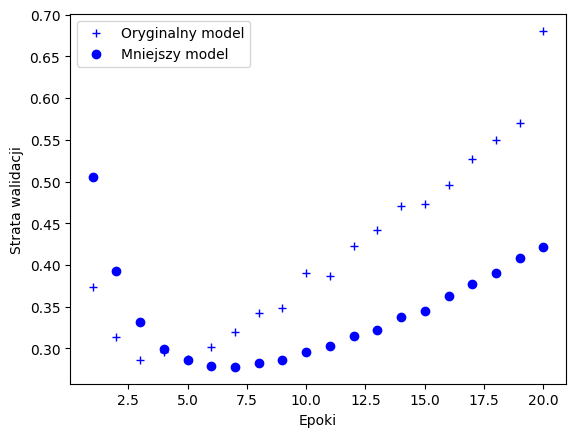

In [8]:
import matplotlib.pyplot as plt

# b+ to niebieskie krzyżyki
plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
# bo to niebieskie kropki
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Mniejszy model')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()


Jak widać, mniejsza sieć zaczęła ulegać nadmiernemu dopasowaniu (przeuczeniu) później niż nasz początkowy model (po sześciu, a nie po czterech epokach), a dodatkowo po przekroczeniu punktu przeuczenia wydajność mniejszego modelu ulega wolniejszej degradacji.

Spróbujmy przeanalizować w tym kontekście działanie sieci o znacznie większej pojemności (przekraczającej potrzeby problemu).

In [9]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [10]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20


2025-01-21 15:37:04.266498: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 12 bytes spill stores, 12 bytes spill loads

2025-01-21 15:37:04.479644: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54_0', 228 bytes spill stores, 228 bytes spill loads

2025-01-21 15:37:04.484900: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 188 bytes spill stores, 188 bytes spill loads

2025-01-21 15:37:04.558546: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54_0', 768 bytes spill stores, 720 bytes spill loads

2025-01-21 15:37:04.592152: I external/local_xla/xla/stre

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6575 - loss: 0.6027

2025-01-21 15:37:05.946977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 204 bytes spill stores, 204 bytes spill loads

2025-01-21 15:37:06.101745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 92 bytes spill stores, 92 bytes spill loads

2025-01-21 15:37:06.207208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 100 bytes spill stores, 100 bytes spill loads

2025-01-21 15:37:06.223959: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 168 bytes spill stores, 168 bytes spill loads

2025-01-21 15:37:06.251676: I external/local_xla/xla/stream

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - acc: 0.6700 - loss: 0.5890 - val_acc: 0.7128 - val_loss: 0.6922
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.8720 - loss: 0.3122 - val_acc: 0.8875 - val_loss: 0.2729
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9211 - loss: 0.2030 - val_acc: 0.8874 - val_loss: 0.2753
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9338 - loss: 0.1700 - val_acc: 0.8328 - val_loss: 0.4502
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9575 - loss: 0.1225 - val_acc: 0.8825 - val_loss: 0.3128
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9750 - loss: 0.0751 - val_acc: 0.8815 - val_loss: 0.3166
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9872 - loss: 0.0469 - val_acc: 0.8157 - val_loss: 0.7520
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9637 - loss: 0.0927 - val_acc: 0.8789 - val_loss: 0.3926
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9975 - loss: 0.

Oto rysnek, na którym porównano wydajność zbyt dużej sieci i naszego początkowego modelu. Kropkami oznaczono stratę walidacji większej sieci, a krzyżykami oznaczono stratę walidacji początkowej wersji sieci.

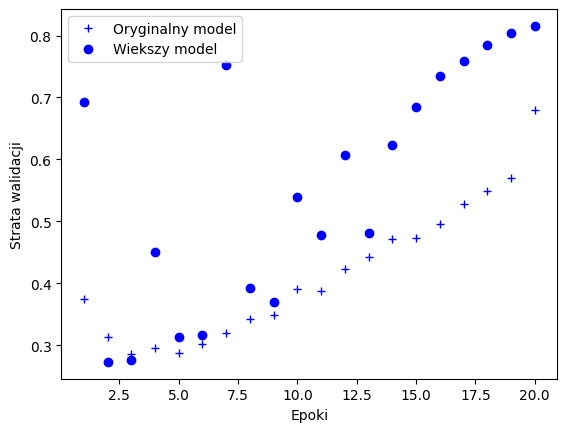

In [11]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Wiekszy model')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()


porównano wydajność zbyt dużej sieci i naszego początkowego modelu. Kropkami oznaczono stratę walidacji większej sieci, a krzyżykami oznaczono stratę walidacji początkowej wersji sieci.

Oto rysunek, na którym porównano straty procesu trenowania dwóch sieci.


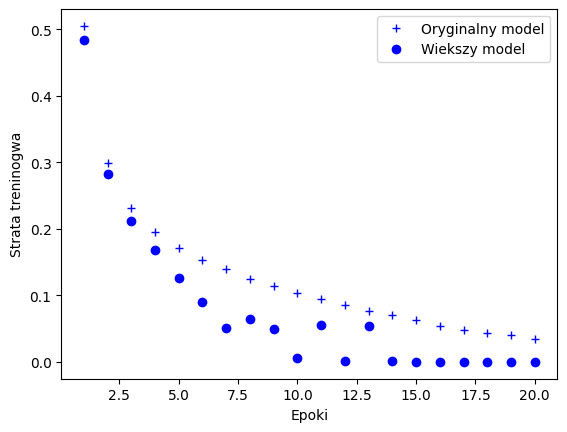

In [12]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Wiekszy model')
plt.xlabel('Epoki')
plt.ylabel('Strata treninogwa')
plt.legend()

plt.show()

Widać, że większa sieć bardzo szybko uzyskuje praktycznie zerową wartość straty treningowej. Im większa jest pojemność sieci, tym szybciej modelowane są dane treningowe (uzyskiwana jest niska wartość straty treningowej), ale wzrasta wówczas podatność na nadmierne dopasowanie (powstaje duża różnica między stratą treningową a stratą walidacji).

## Dodawanie regularyzacji wag


Przypomnijmy zasadę brzytwy Ockhama. Według niej, jeżeli istnieją dwa wyjaśnienia jakiejś teorii, to najprawdopodobniej poprawnym wyjaśnieniem jest to, które jest prostsze — to, które czyni mniej założeń. Zasada ta sprawdza się również w kontekście modeli sieci neuronowych: jeżeli mamy dane treningowe, architekturę sieci i wiele zbiorów wartości wag (wiele modeli) opisujących dane, to prostsze modele są mniej podatne na nadmierne dopasowanie od tych, które są bardziej złożone.

Przyjmijmy, że za prostszy model uważamy model, którego rozkład wartości parametrów charakteryzuje się mniejsza entropią, lub model, który ma mniej parametrów. W związku z tym popularną techniką unikania nadmiernego dopasowania jest wymuszenie na modelu ograniczenia złożoności poprzez przyjmowanie tylko małych wartości wag, co sprawia, że rozkład wartości wag jest bardziej regularny. Zabieg ten określamy mianem regularyzacji wag. Implementuje się go poprzez dodanie do funkcji straty sieci kosztu związanego z dużymi wartościami wag. W praktyce można to zrobić na dwa sposoby:


* Regularyzacja L1 — koszt jest dodawany proporcjonalnie do bezwzględnej wartości współczynników wag (normy L1 wag).

* Regularyzacja L2 — koszt jest dodawany proporcjonalnie do kwadratu wartości współczynników wag (normy L2 wag). W kontekście sieci neuronowych regularyzacja L2 jest również określana mianem rozkładu wag. Pomimo innej nazwy jest to ten sam proces, który w matematyce określamy jako regularyzacja L2.

W pakiecie Keras regularyzację wag dodaje się poprzez przekazanie instancji regularyzatora wagi do warstw sieci za pomocą argumentu w formie słowa kluczowego. Dodajmy regularyzację L2 wag do sieci klasyfikatora recenzji filmów.

In [13]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

Argument l2(0.001) oznacza, że każdy współczynnik macierzy wag warstwy doda wartość równą 0.001 * weight_coefficient_value (0,001 razy wartość współczynnika wagi) do całkowitej straty sieci. Kara ta jest dodawana tylko podczas trenowania, a więc strata sieci w czasie trenowania będzie o wiele wyższa niż w czasie testowania.

Oto wykres, na którym pokazano wpływ kary w postaci regularyzacji L2:

In [15]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.7173 - loss: 0.6305 - val_acc: 0.8762 - val_loss: 0.4039
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8971 - loss: 0.3519 - val_acc: 0.8818 - val_loss: 0.3492
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9157 - loss: 0.2849 - val_acc: 0.8884 - val_loss: 0.3293
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9284 - loss: 0.2504 - val_acc: 0.8765 - val_loss: 0.3550
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9349 - loss: 0.2390 - val_acc: 0.8838 - val_loss: 0.3397
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9392 - loss: 0.2255 - val_acc: 0.8831 - val_loss: 0.3466
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9434 - loss: 0.2166 - val_acc: 0.8716 - val_loss: 0.3786
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9483 - loss: 0.2084 - val_acc: 0.8794 - val_loss: 0.3611
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9507

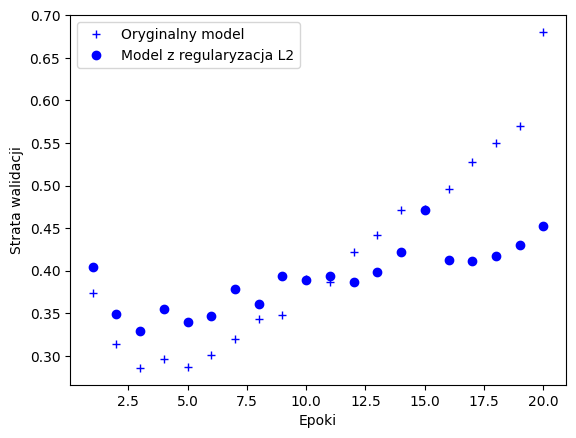

In [17]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='Model z regularyzacja L2')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()



Jak widać, model z regularyzacją L2 (kropki) stał się o wiele bardziej odporny na nadmierne dopasowanie od modelu referencyjnego (krzyżyki) pomimo tego, że oba modele charakteryzują się identyczną liczbą parametrów.

Zamiast regularyzacji L2 możesz korzystać również z innych mechanizmów regularyzacji obsługiwanych przez pakiet Keras.

In [18]:
from tensorflow.keras import regularizers

# Regularyzacja L1.
regularizers.l1(0.001)

# Jednoczesna regularyzacja L1 i L2.
regularizers.l1_l2(l1=0.001, l2=0.001)

## Porzucanie — technika dropout


Porzucanie (ang. droput) jest jedną z najbardziej skutecznych i najpopularniejszych technik regularyzacji sieci neuronowych. Opracował ją Geoff Hinton podczas współpracy ze swoimi studentami na Uniwersytecie w Toronto. Technika ta polega na losowym wybieraniu pewnej liczby cech wyjściowych warstwy podczas trenowania (wartości tych warstw są zastępowane zerami). Załóżmy, że w czasie trenowania warstwa sieci normalnie zwraca wektor [0.2, 0.5, 1.3, 0.8, 1.1]. Po przeprowadzeniu operacji porzucania w wektorze tym (w losowo wybranych miejscach) pojawią się zera i uzyska on np. formę [0, 0.5, 1.3, 0, 1.1]. Ułamek określający część wyzerowanych cech nazywamy współczynnikiem porzucania (ang. dropout rate). Zwykle parametr ten przyjmuje wartość znajdującą się w przedziale od 0,2 do 0,5. Podczas testowania żadne jednostki nie są porzucane — wartości wyjściowe warstwy sieci są skalowane o współczynnik równy współczynnikowi porzucania. Równoważy to aktywność większej liczby jednostek podczas testowania niż trenowania.

Przyjrzyjmy się macierzy Numpy zawierającej warstwę wyjściową layer_output o kształcie (rozmiar_wsadu, liczba_cech). W czasie trenowania wyzerowaliśmy losową część wartości tej macierzy:

In [21]:
# Podczas trenowania porzucane jest 50% jednostek wyjściowych.
layer_output = 1
layer_output *= np.random.randint(0, high=2)
#layer_output *= np.randint(0, high=2, size=layer_output.shape)


Podczas testowania skalujemy wartości wyjściowe o współczynnik porzucania. W tym przypadku przeprowadzamy skalowanie o współczynnik 0,5 (wcześniej odrzucaliśmy połowę jednostek):

In [22]:
# W czasie testowania:
layer_output *= 0.5


Zauważ, że proces ten można zaimplementować, wykonując obie operacje podczas trenowania i pozostawiając dane wyjściowe bez zmian w czasie testowania. Rozwiązanie takie jest często używane w praktyce:

In [23]:
# W czasie trenowania.
#layer_output *= np.randint(0, high=2, size=layer_output.shape)
layer_output *= np.random.randint(0, high=2)
# Zwróć wuagę na to, że w tym przypadku skalujemy raczej w górę niż w dół.
layer_output /= 0.5


Technika ta może wydawać się dziwna i chaotyczna. Jak ma pomóc w zmniejszeniu nadmiernego dopasowania? Hinton tworząc ją, inspirował się mechanizmami zapobiegającymi nadużyciom stosowanym przez banki. Stwierdził: „Pewnego dnia, gdy poszedłem do banku, zauważyłem, że osoby w okienkach często zmieniają swoje miejsca; pracownicy banku nie potrafili powiedzieć, dlaczego to robią, ale doszedłem do wniosku, że przy takiej rotacji wyłudzenie pieniędzy z banku wymagałoby współpracy wielu pracowników; wówczas zdałem sobie sprawę, że losowe usuwanie różnych podzbiorów neuronów podczas przetwarzania każdego przykładu zapobiegnie konspiracji i zredukuje nadmierne dopasowanie”. Główną ideą tej techniki jest wprowadzenie szumu do wartości wyjściowych warstwy w celu pozbycia się nieznaczących wzorców (Hinton określił je mianem „konspiracji”) — wprowadzenie szumu zapobiega zapamiętywaniu takich wzorców przez sieć.

W pakiecie Keras technikę tę można zastosować przy użyciu warstwy Dropout, którą umieszcza się bezpośrednio za wyjściem znajdującej się wcześniej warstwy:


model.add(layers.Dropout(0.5))

Dodajmy dwie warstwy Dropout do sieci IMDB i zobaczmy, czy pomogą one w zredukowaniu nadmiernego dopasowania:

In [24]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - acc: 0.6236 - loss: 0.6327 - val_acc: 0.8680 - val_loss: 0.4524
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8131 - loss: 0.4654 - val_acc: 0.8829 - val_loss: 0.3415
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8646 - loss: 0.3795 - val_acc: 0.8887 - val_loss: 0.2988
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8980 - loss: 0.3092 - val_acc: 0.8894 - val_loss: 0.2899
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9164 - loss: 0.2701 - val_acc: 0.8886 - val_loss: 0.2828
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9237 - loss: 0.2399 - val_acc: 0.8882 - val_loss: 0.2834
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9308 - loss: 0.2118 - val_acc: 0.8868 - val_loss: 0.3050
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9440 - loss: 0.1906 - val_acc: 0.8814 - val_loss: 0.3453
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9447

Czas przedstawić wyniki na wykresie:

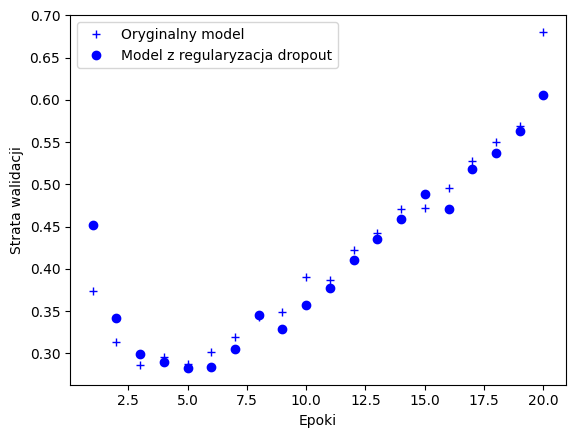

In [26]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Model z regularyzacja dropout')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()


Ponownie widać poprawę względem sieci referencyjnej.

Reasumując, oto najczęściej stosowane techniki mające zapobiec nadmiernemu dopasowaniu sieci neuronowych:

* Zdobycie większej ilości danych treningowych.
* Redukcja pojemności sieci.
* Dodanie regularyzacji wag.
* Dodanie mechanizmu porzucania.

## Zadania do wykonania

1. Uzupełnić materiały o własne przemyślenia, wnioski, grafiki, schematy...